In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
## Adding in some more useful packages here
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
#from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Koushik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#read the data
train = pd.read_csv(r'C:\Users\Koushik\Desktop\hackathon\train.tsv',sep='\t')

## Insights on the Data  

In [3]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Percent of Neutral entries 206.358 %


,PhraseId,SentenceId,Phrase,Sentiment
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2


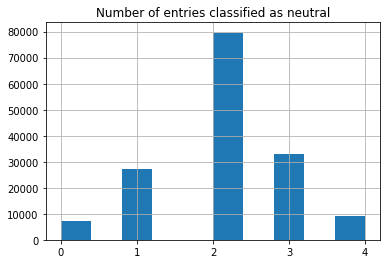

In [26]:
fig,ax = plt.subplots(1,1)
train.hist(column = 'Sentiment', ax = ax)
ax.set_title('Number of entries classified as neutral')
ax.set_xticks([0,1,2,3,4])
print('Percent of Neutral entries %.3f %%'%(100*(sum(train['Sentiment'])/len(train))))

train[train['Sentiment']==2].head()

## Load Glove model
GloVe, coined from Global Vectors, is a model for distributed word representation. The model is an unsupervised learning algorithm for obtaining vector representations for words. This is achieved by mapping words into a meaningful space where the distance between words is related to semantic similarity

In [5]:
#Loading Glove840B.300d 
embeddings_index = {}
f = open('C:\\Users\\Koushik\\Desktop\\hackathon\\Glove\\glove.840B.300d.txt',encoding='utf8')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


## Clean the data 

In [6]:
#clean sentences
import re
lines_without_stopwords=[] 
for line in train['Phrase'].values: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE)
    new_line = []
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords
print(texts[:5])

[['series', 'escapades', 'demonstrating', 'adage', 'good', 'goose', 'also', 'good', 'gander', 'occasionally', 'amuses', 'none', 'amounts', 'much', 'story'], ['series', 'escapades', 'demonstrating', 'adage', 'good', 'goose'], ['series'], [], ['series']]


In [7]:
## Code adapted from (https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)
# Vectorize the text samples
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = 50
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(train['Sentiment'])
test_final = train['Sentiment']
print(data.shape)
print(labels.shape)
print(test_final.shape)

Using TensorFlow backend.


Found 15142 unique tokens.
(156060, 50)
(156060, 5)
(156060,)


In [8]:
## More code adapted from the keras reference (https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)
# prepare embedding matrix 
from keras.layers import Embedding
from keras.initializers import Constant

## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [9]:
#splitthe data to train and test in 75:25 ratio
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)
test_final = test_final[117045:]
print(X_train.shape)
print(y_test.shape)
print(test_final.shape)

(117045, 50)
(39015, 5)
(39015,)


In [10]:
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
import gc
#max_features = num_unique_word
max_words = MAX_SEQUENCE_LENGTH
batch_size = 128
epochs = 3
num_classes=5

## LSTM with Glove and trainable = True
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series.
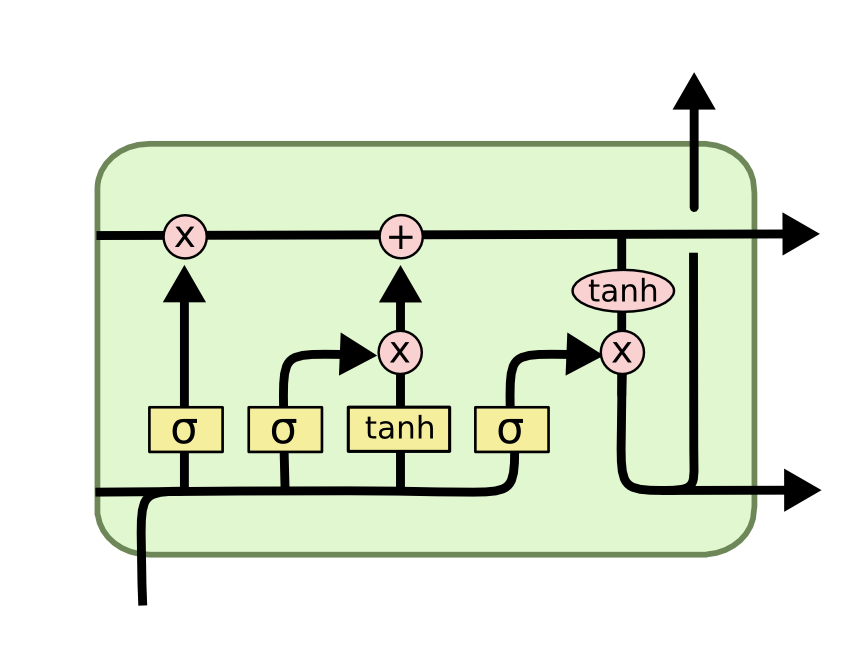

In [12]:
#using LSTM with GLOVE
model1=Sequential()
#model1.add(Embedding(13732,100,mask_zero=True))
model1.add(Embedding(num_words, 300, input_length=50, weights= [embedding_matrix], trainable=True))
model1.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model1.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model1.add(LSTM(8,dropout=0.4, recurrent_dropout=0.4,return_sequences=False))
model1.add(Dense(num_classes,activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 300)           300300    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 64)            93440     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 32)            12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 45        
Total params: 407,513
Trainable params: 407,513
Non-trainable params: 0
_________________________________________________________________


In [13]:
%%time
history1=model1.fit(X_train, y_train, validation_split=0.1,epochs=epochs, batch_size=batch_size, verbose=1)


Train on 105340 samples, validate on 11705 samples
Epoch 1/3
105340/105340 [==============================] - 402s 4ms/step - loss: 1.1872 - acc: 0.5418 - val_loss: 1.0864 - val_acc: 0.5841
Epoch 2/3
105340/105340 [==============================] - 427s 4ms/step - loss: 1.0952 - acc: 0.5767 - val_loss: 1.0621 - val_acc: 0.5898
Epoch 3/3
105340/105340 [==============================] - 416s 4ms/step - loss: 1.0779 - acc: 0.5830 - val_loss: 1.0523 - val_acc: 0.5937
Wall time: 20min 55s


In [14]:
#predicitng actual values
y_pred1=model1.predict_classes(X_test,verbose=1)

39015/39015 [==============================] - 67s 2ms/step


## CNN & GRU with Glove weights and trainable = True
 Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks.The GRU is like a long short-term memory (LSTM) with forget gate but has fewer parameters than LSTM.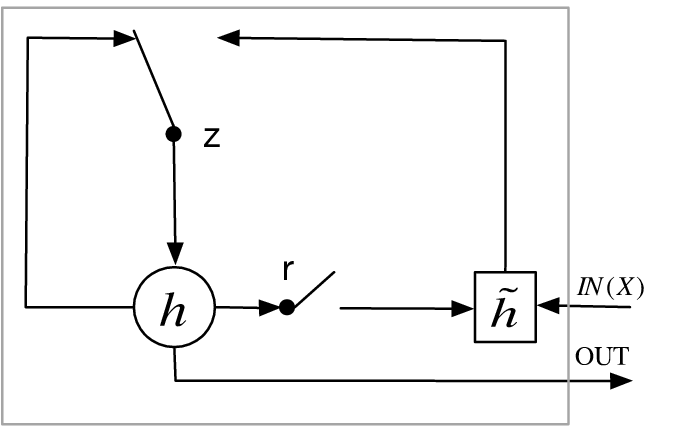

In [15]:
#CNN +GRU
model2= Sequential()
model2.add(Embedding(num_words,300,input_length=50,weights= [embedding_matrix], trainable=True))
model2.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.25))
model2.add(GRU(256,return_sequences=True))
model2.add(Dropout(0.65))
model2.add(GRU(128,return_sequences=True))
model2.add(Dropout(0.6))
model2.add(GRU(64,return_sequences=True))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(5,activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 300)           300300    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 64)            57664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 25, 256)           246528    
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 25, 128)           147840    
__________

In [16]:
%%time
history1=model2.fit(X_train, y_train, validation_split=0.1,epochs=epochs, batch_size=batch_size, verbose=1)


Train on 105340 samples, validate on 11705 samples
Epoch 1/3
105340/105340 [==============================] - 721s 7ms/step - loss: 1.1444 - acc: 0.5589 - val_loss: 1.0607 - val_acc: 0.5906
Epoch 2/3
105340/105340 [==============================] - 716s 7ms/step - loss: 1.0817 - acc: 0.5820 - val_loss: 1.0411 - val_acc: 0.5932
Epoch 3/3
105340/105340 [==============================] - 652s 6ms/step - loss: 1.0553 - acc: 0.5908 - val_loss: 1.0240 - val_acc: 0.6006
Wall time: 34min 55s


In [18]:
y_pred2=model2.predict_classes(X_test,verbose=1)

39015/39015 [==============================] - 79s 2ms/step


## CNN & GRU with Glove weights and trainable = false

In [18]:
#CNN +GRU
model3= Sequential()
model3.add(Embedding(num_words,300,input_length=50,weights= [embedding_matrix], trainable=False))
model3.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.25))
model3.add(GRU(128,return_sequences=True))
model3.add(Dropout(0.3))
model3.add(GRU(64,return_sequences=True))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(128,activation='relu'))
model3.add(Dropout(0.8))
model3.add(Dense(5,activation='softmax'))
model3.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           300300    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 64)            57664     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25, 64)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 25, 128)           74112     
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 25, 64)            37056     
__________

In [19]:
%%time
history1=model3.fit(X_train, y_train, validation_split=0.1,epochs=epochs, batch_size=batch_size, verbose=1)


Train on 105340 samples, validate on 11705 samples
Epoch 1/3
105340/105340 [==============================] - 229s 2ms/step - loss: 1.1768 - acc: 0.5489 - val_loss: 1.0741 - val_acc: 0.5825
Epoch 2/3
105340/105340 [==============================] - 233s 2ms/step - loss: 1.1163 - acc: 0.5664 - val_loss: 1.0602 - val_acc: 0.5881
Epoch 3/3
105340/105340 [==============================] - 231s 2ms/step - loss: 1.0946 - acc: 0.5736 - val_loss: 1.0473 - val_acc: 0.5880
Wall time: 11min 34s


In [35]:
y_pred3=model3.predict_classes(X_test,verbose=1)

39015/39015 [==============================] - 27s 702us/step


## Have a view at the top negative words 

In [25]:
to_put_to_csv = train[int(train.shape[0]*0.75):] 
df = pd.DataFrame({"Phrase": to_put_to_csv["Phrase"], "prediction": y_pred2})
#df.prediction.head()
#df.to_csv(r'C:\Users\Koushik\Desktop\hackathon\submission.csv', index=False)

In [22]:
negative_words = df

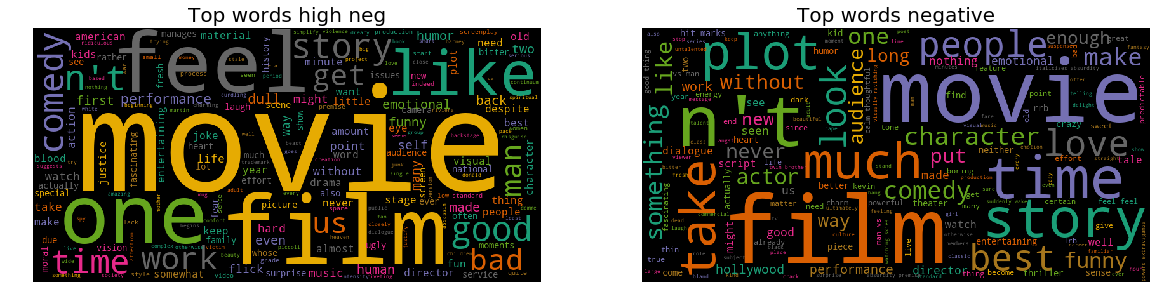

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
n_posts = 1000
q_S = ' '.join(negative_words[negative_words['prediction'] == 0]['Phrase'].str.lower().values[:n_posts])
q_I = ' '.join(negative_words[negative_words['prediction'] == 1]['Phrase'].str.lower().values[:n_posts])

wordcloud_S = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_S)
wordcloud_I = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_I)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(wordcloud_S)
ax[0].set_title('Top words high neg',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_I)
ax[1].set_title('Top words negative',fontsize = 20)
ax[1].axis("off")

plt.show()